In [1]:
import os
import numpy as np
import typing as t
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from v1t.utils import utils, yaml, tensorboard

utils.set_random_seed(1234)

tensorboard.set_font()

In [2]:
cnn_paths = {
    4500: "../runs/limit_data/020_cnn_all",
    3500: "../runs/limit_data/021_cnn_3500",
    2500: "../runs/limit_data/022_cnn_2500",
    1500: "../runs/limit_data/023_cnn_1500",
    500: "../runs/limit_data/024_cnn_500",
}

v1t_paths = {
    4500: "../runs/limit_data/001_v1t_all",
    3500: "../runs/limit_data/002_v1t_3500",
    2500: "../runs/limit_data/003_v1t_2500",
    1500: "../runs/limit_data/004_v1t_1500",
    500: "../runs/limit_data/005_v1t_500",
}

In [3]:
def load_results(paths: t.Dict[int, str]):
    results = {}
    for sample_size, path in paths.items():
        filename = os.path.join(path, "evaluation.yaml")
        if os.path.exists(filename):
            result = yaml.load(filename)
            single_trial_correlation = result["single_trial_correlation"]
            single_trial_correlation.pop("average", None)
            results[sample_size] = single_trial_correlation
        else:
            results[sample_size] = None
    return results

In [4]:
cnn_results = load_results(cnn_paths)
v1t_results = load_results(v1t_paths)

In [5]:
def get_mean_std(results: t.Dict[int, t.Dict[str, float]], sample_sizes: t.List[int]):
    mean, std = [], []
    for sample_size in sample_sizes:
        if results[sample_size] is not None:
            values = list(results[sample_size].values())
            mean.append(np.mean(values))
            std.append(np.std(values))
        else:
            mean.append(0)
            std.append(0)
    return mean, std

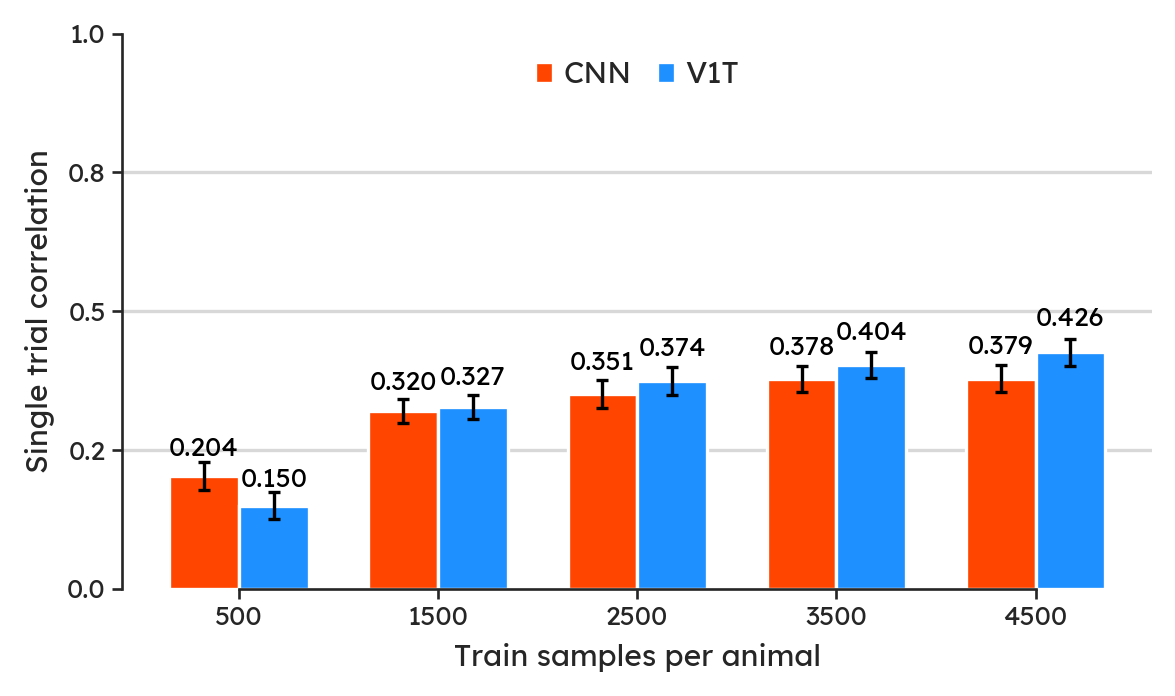

In [13]:
tick_fontsize, label_fontsize = 8, 9
width, y_max = 0.35, 1.0
error_kw = {"elinewidth": 1, "capsize": 1.8}
figure, axis = plt.subplots(
    nrows=1, ncols=1, figsize=(5, 3), dpi=240, facecolor="white"
)

x_axis = np.arange(1, len(cnn_results) + 1)
x_labels = sorted(list(cnn_results.keys()))

# plot CNN results
cnn_mean, cnn_std = get_mean_std(cnn_results, x_labels)
axis.bar(
    x_axis - width / 2,
    height=cnn_mean,
    yerr=cnn_std,
    width=width,
    align="center",
    label="CNN",
    color="orangered",
    error_kw=error_kw,
)
for i in range(len(cnn_mean)):
    axis.text(
        x_axis[i] - width / 2,
        (cnn_mean[i] + cnn_std[i]) * 1.05,
        f"{cnn_mean[i]:.03f}",
        ha="center",
        color="black",
        fontsize=tick_fontsize,
    )

# plot V1T results
v1t_mean, v1t_std = get_mean_std(v1t_results, x_labels)
axis.bar(
    x_axis + width / 2,
    height=v1t_mean,
    yerr=v1t_std,
    width=width,
    align="center",
    label="V1T",
    color="dodgerblue",
    error_kw=error_kw,
)
for i in range(len(cnn_mean)):
    axis.text(
        x_axis[i] + width / 2,
        (v1t_mean[i] + v1t_std[i]) * 1.05,
        f"{v1t_mean[i]:.03f}",
        ha="center",
        color="black",
        fontsize=tick_fontsize,
    )

axis.legend(
    loc="upper center",
    ncols=2,
    frameon=False,
    handletextpad=0.35,
    handlelength=0.6,
    markerscale=0.8,
    columnspacing=0.85,
    fontsize=label_fontsize,
)

tensorboard.set_xticks(
    axis,
    ticks_loc=x_axis,
    ticks=x_labels,
    label="Train samples per animal",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
axis.set_ylim(0, y_max)
y_ticks = np.linspace(0, y_max, 5)
tensorboard.set_yticks(
    axis,
    ticks_loc=y_ticks,
    ticks=y_ticks.round(1),
    label="Single trial correlation",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
sns.despine(ax=axis, top=True, right=True, trim=True)
# plot y-axis grid lines
for y_value in y_ticks:
    if 0 < y_value < y_max:
        axis.axhline(y_value, color="gray", alpha=0.3, linewidth=1, zorder=0)

figure.tight_layout()

tensorboard.save_figure(figure, filename=f"plots/limit_data.pdf", dpi=240, close=False)

plt.show()
plt.close(figure)